# Competition for glucose, with internal goods X and Y, and social objective (model), Time-step growth model

##Here, the case is cell type3 existing regulation to cell type2. Only not receive the regulation from cell type2.

In [1]:
import cobra
import pandas as pd
import numpy as np
import pickle
from cobra.flux_analysis import pfba

In [2]:
# import map visualization tools
from utils import show_map
import escher
map_loc = 'Three_cells_system_modelIIMap.json' # the escher map used below
# show all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

M = cobra.io.load_json_model('Three_cells_system_modelII.json')
model = M.copy()

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


/Users/yanhualiu/Desktop/New_topic/model_building/model_building_exercise_by_yanhua/Cells' competition paper/Three cell types considering growth for paper/Cell types just including one mutation as cell type1/utils/findBiomarkers.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [57]:
b = show_map([],map_loc)
b

An empty solution was passed.


Builder(hide_secondary_metabolites=False, highlight_missing=True, reaction_data={}, reaction_scale=[{'type': '…

In [3]:
### Internal goods X and Y
model.reactions.EX_Com_goodX_e.lower_bound=0
model.reactions.EX_Com_goodY_e.lower_bound=0
model.reactions.EX_glucose_e.lower_bound=-1
quadratic_objective = M.problem.Objective(model.reactions.biomass1.flux_expression +
    model.reactions.biomass2.flux_expression + model.reactions.biomass3.flux_expression ,direction='max')
model.objective = quadratic_objective

In [4]:
sol = model.optimize()
sol.objective_value
fbasol = model.optimize()
b = show_map(fbasol,map_loc)
b

0.5

Builder(hide_secondary_metabolites=False, highlight_missing=True, reaction_data={'EX_glucose_e': -1.0, 'GlcT':…

In [6]:
### FVA result
rxnsOfInterest=['EX_glucose_e','GlcT','GTI1','GTI2','GTI3',
                'biomass1','biomass2','biomass3','DI1X','DI2Y']
fvasol = cobra.flux_analysis.flux_variability_analysis(model,reaction_list=rxnsOfInterest,fraction_of_optimum=1)
fvasol

,minimum,maximum
EX_glucose_e,-1.00,-1.00
GlcT,1.00,1.00
GTI1,0.00,0.75
GTI2,0.25,0.75
GTI3,0.00,0.75
biomass1,0.00,0.50
biomass2,0.00,0.50
biomass3,0.00,0.50
DI1X,0.00,0.25
DI2Y,0.25,0.25


# Time stepwise growth calculation (The influence of cells' inherent grwoth rate)

### u1<u2<u3 [0.2, 0.3, 0.35] Here we will use a lower growth rate for cell type3.

In [5]:
import math
model1=model.copy()
model2=model1.copy()

<Figure size 640x480 with 0 Axes>

0.1885 0.2828 0.0287


Text(0.5, 0, 't (month)')

(0.0, 1.0)

Text(0.5, 1.0, 'Stepwise growth (µ1=0.2, µ2=0.3, µ3=0.35; $\\varepsilon=1$)')

Text(0, 0.5, 'Cell number (billions)')

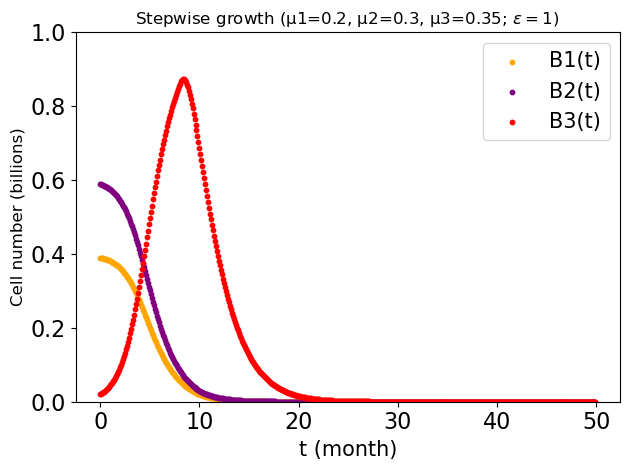

In [8]:
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.1885]
Fluxes2_list=[0.2828]
Fluxes3_list=[0.0287]
B1_vals=[0.39]
B2_vals=[0.59]
B3_vals=[0.02]

def B1(t):
    if(t<=0):
        return 0.39
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=0):
        return 0.59
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=0):
        return 0.02
    return B3_vals[int((t-1)/1)]*0.95+0.1*Fluxes3_list[-1]

for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)
   
    b1=0.5*0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))+0.35*B3_vals[-1])
    b2=0.5*0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))+0.35*B3_vals[-1])
    b3=0.5*0.35*B3_vals[-1]/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))+0.35*B3(t-0.1))
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t)
    
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes3=sol.fluxes.loc['biomass3']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes1=sol.fluxes.loc['biomass1']

    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)
    
    T=t/10
    T_list.append(T)
            
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0])

# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes3_list,color='red',s=10)
plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
plt.scatter(T_list,B3_vals,color='red',s=10)

plt.xlabel("t (month)",fontsize=15)
# plt.ylabel("Biomass synthesis value")
# plt.legend(['b1(t)','b2(t)','b3(t)'])
plt.ylim(0,1)
# plt.hlines(y=0.4, xmin=0, xmax=50,colors='black', linestyles='solid',linewidth=2)
plt.title('Stepwise growth (µ1=0.2, µ2=0.3, µ3=0.35; 'r'$\varepsilon=1$'')',fontsize=12)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)','B2(t)','B3(t)'],loc='upper right')
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()
# plt.show()
plt.savefig('Only regulation between biomass1 and biomass2(Obj=b1+b2+b3)',dpi=600)

###  u1<u3<u2 [0.2, 0.25, 0.3]

In [9]:
import math
model1=model.copy()
model2=model1.copy()

<Figure size 640x480 with 0 Axes>

0.1917 0.2875 0.0208


Text(0.5, 0, 't (month)')

(0.0, 1.0)

Text(0.5, 1.0, 'Stepwise growth (µ1=0.2, µ2=0.3, µ3=0.25; $\\varepsilon=1$)')

Text(0, 0.5, 'Cell number (billions)')

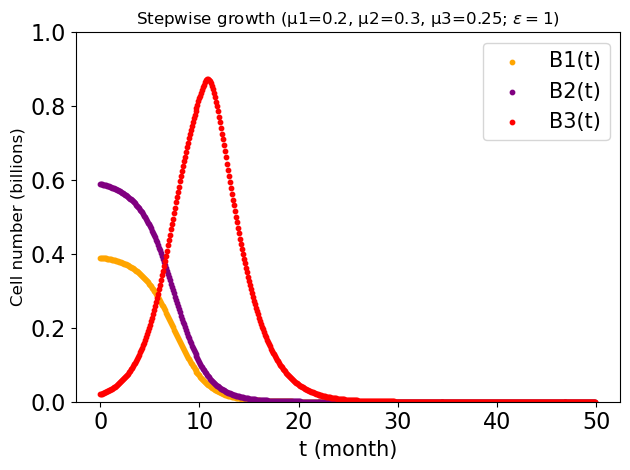

In [10]:
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.1917]
Fluxes2_list=[0.2875]
Fluxes3_list=[0.0208]
B1_vals=[0.39]
B2_vals=[0.59]
B3_vals=[0.02]

def B1(t):
    if(t<=0):
        return 0.39
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=0):
        return 0.59
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=0):
        return 0.02
    return B3_vals[int((t-1)/1)]*0.95+0.1*Fluxes3_list[-1]

for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)
    
    b1=0.5*0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))+0.25*B3_vals[-1])
    b2=0.5*0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))+0.25*B3_vals[-1])
    b3=0.5*0.25*B3_vals[-1]/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))+0.25*B3(t-0.1))
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t)
    
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes3=sol.fluxes.loc['biomass3']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes1=sol.fluxes.loc['biomass1']

    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)
    
    T=t/10
    T_list.append(T)
            
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0])

# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes3_list,color='red',s=10)
plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
plt.scatter(T_list,B3_vals,color='red',s=10)

plt.xlabel("t (month)",fontsize=15)
# plt.ylabel("Biomass synthesis value")
# plt.legend(['b1(t)','b2(t)','b3(t)'])
plt.ylim(0,1)
# plt.hlines(y=0.4, xmin=0, xmax=50,colors='black', linestyles='solid',linewidth=2)
plt.title('Stepwise growth (µ1=0.2, µ2=0.3, µ3=0.25; 'r'$\varepsilon=1$'')',fontsize=12)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)','B2(t)','B3(t)'],loc='upper right')
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()
# plt.show()
plt.savefig('Only regulation between biomass1 and biomass2(Obj=b1+b2+b3)',dpi=600)

###  u3<u1<u2 [0.15, 0.2, 0.3]

In [11]:
import math
model1=model.copy()
model2=model1.copy()

<Figure size 640x480 with 0 Axes>

0.1949 0.2924 0.0127


Text(0.5, 0, 't (month)')

(0.0, 1.0)

Text(0.5, 1.0, 'Stepwise growth (µ1=0.2, µ2=0.3, µ3=0.15; $\\varepsilon=1$)')

Text(0, 0.5, 'Cell number (billions)')

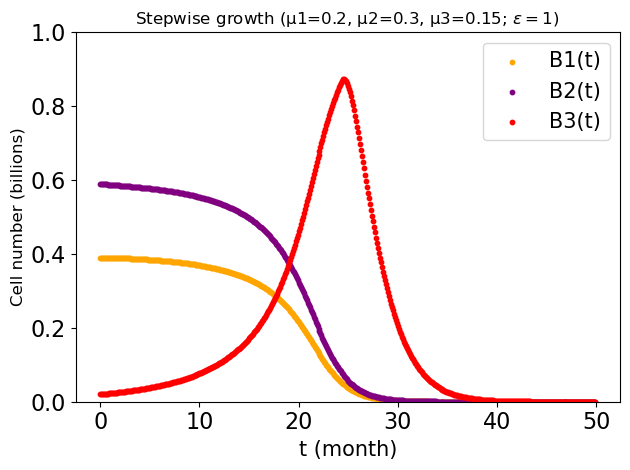

In [12]:
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.1949]
Fluxes2_list=[0.2924]
Fluxes3_list=[0.0127]
B1_vals=[0.39]
B2_vals=[0.59]
B3_vals=[0.02]

def B1(t):
    if(t<=0):
        return 0.39
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=0):
        return 0.59
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=0):
        return 0.02
    return B3_vals[int((t-1)/1)]*0.95+0.1*Fluxes3_list[-1]

for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)
    
    b1=0.5*0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))+0.15*B3_vals[-1])
    b2=0.5*0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))+0.15*B3_vals[-1])
    b3=0.5*0.15*B3_vals[-1]/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))+0.15*B3(t-0.1))
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t)
    
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes3=sol.fluxes.loc['biomass3']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes1=sol.fluxes.loc['biomass1']

    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)
    
    T=t/10
    T_list.append(T)
            
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0])

# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes3_list,color='red',s=10)
plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
plt.scatter(T_list,B3_vals,color='red',s=10)

plt.xlabel("t (month)",fontsize=15)
# plt.ylabel("Biomass synthesis value")
# plt.legend(['b1(t)','b2(t)','b3(t)'])
plt.ylim(0,1)
# plt.hlines(y=0.4, xmin=0, xmax=50,colors='black', linestyles='solid',linewidth=2)
plt.title('Stepwise growth (µ1=0.2, µ2=0.3, µ3=0.15; 'r'$\varepsilon=1$'')',fontsize=12)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)','B2(t)','B3(t)'],loc='upper right')
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize']=15
plt.tight_layout()
# plt.show()
plt.savefig('Only regulation between biomass1 and biomass2(Obj=b1+b2+b3)',dpi=600)

## High growth with regulation and lower growth rate without regulation

###  u1<u2<u3 [0.2, 0.3, 0.35]

In [8]:
import math
model1=model.copy()
model2=model1.copy()

<Figure size 640x480 with 0 Axes>

0.1885 0.2828 0.0287


Text(0.5, 0, 't (month)')

Text(0.5, 1.0, 'Stepwise growth (µ1=0.2,µ2=0.3,µ3=0.35 ; $\\varepsilon=1$; $\\gamma=0$)')

(0.0, 1.0)

Text(0, 0.5, 'Cell number (billions)')

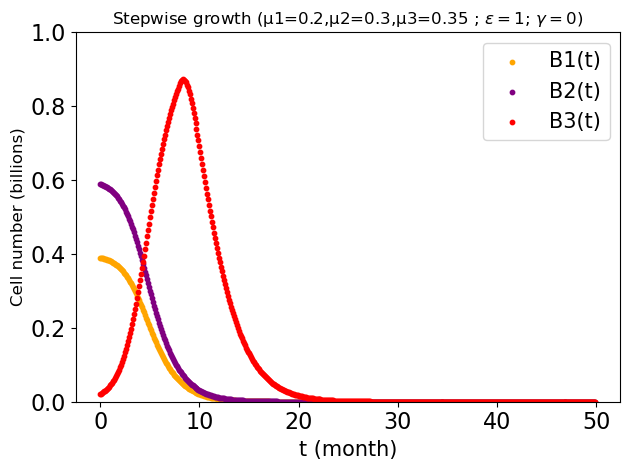

In [9]:
### 𝛆=1;𝞬=0;Fluxes1=0.1885; Fluxes2=0.2828; Fluxes3=0.0287
### 𝛆=1;𝞬=0.8;Fluxes1=0.1399; Fluxes2=0.2099; Fluxes3=0.1502
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.1885]
Fluxes2_list=[0.2828]
Fluxes3_list=[0.0287]
B1_vals=[0.39]
B2_vals=[0.59]
B3_vals=[0.02]

def B1(t):
    if(t<=0):
        return 0.39
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=0):
        return 0.59
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=0):
        return 0.02
    return B3_vals[int((t-1)/1)]*0.95+0.1*Fluxes3_list[-1]
A=0
u3=0.35
for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)
    
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
#     B3_vals.append(B3_t)
    
    b1=0.5*0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))*(math.pow(B3_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))*(math.pow(B3_vals[-1],A))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))*(math.pow(B3_vals[-1],A))+u3*B3_vals[-1]*(math.pow(B1_vals[-1],A))*(math.pow(B2_vals[-1],A))) 
    b2=0.5*0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))*(math.pow(B3_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))*(math.pow(B3_vals[-1],A))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))*(math.pow(B3_vals[-1],A))+u3*B3_vals[-1]*(math.pow(B1_vals[-1],A))*(math.pow(B2_vals[-1],A)))
    b3=0.5*u3*B3_vals[-1]*(math.pow(B1_vals[-1],A))*(math.pow(B2_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))*(math.pow(B3_vals[-1],A))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))*(math.pow(B3_vals[-1],A))+u3*B3_vals[-1]*(math.pow(B1_vals[-1],A))*(math.pow(B2_vals[-1],A)))
    
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t)
    
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes1=sol.fluxes.loc['biomass1']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes3=sol.fluxes.loc['biomass3']
  
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)

    T=t/10
    T_list.append(T)
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0])
# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes3_list,color='red',s=10)
plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
plt.scatter(T_list,B3_vals,color='red',s=10)


plt.xlabel("t (month)",fontsize=15)
plt.title('Stepwise growth (µ1=0.2,µ2=0.3,µ3=0.35 ; 'r'$\varepsilon=1$''; 'r'$\gamma=0$'')',fontsize=12)
# plt.ylabel("Biomass value (B) and biomass synthesis rate (b)")
# plt.legend(['b1(t)','b2(t)','b3(t)','B1(t)','B2(t)','B3(t)'])
plt.ylim(0,1)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)','B2(t)','B3(t)'],loc='upper right')

# plt.ylim(0,0.5)
# plt.ylabel("Biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)','b2(t)','b3(t)'],loc='upper right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize'] = 15
plt.tight_layout()
# plt.show()
plt.savefig('Regulation among three cell types (Obj=b1+b2+b3)',dpi=600)

###  u3<u1<u2 [0.15, 0.2, 0.3]

In [12]:
import math
model1=model.copy()
model2=model1.copy()

<Figure size 640x480 with 0 Axes>

0.1689 0.2534 0.0777


Text(0.5, 0, 't (month)')

Text(0.5, 1.0, 'Stepwise growth (µ1=0.2,µ2=0.3,µ3=0.15 ; $\\varepsilon=1$; $\\gamma=0.8$)')

(0.0, 1.0)

Text(0, 0.5, 'Cell number (billions)')

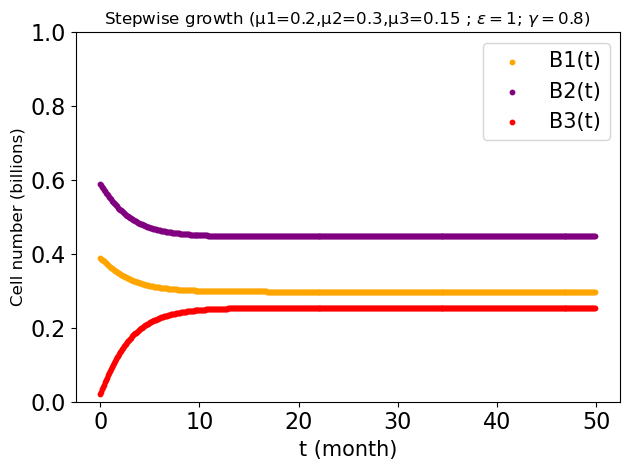

In [13]:
### 𝛆=1;𝞬=0;Fluxes1=0.1949; Fluxes2=0.2924; Fluxes3=0.0127
### 𝛆=1;𝞬=0.8;Fluxes1=0.1689; Fluxes2=0.2534; Fluxes3=0.0777
import matplotlib.pyplot as plt
plt.figure()
T_list=[0]
Fluxes1_list=[0.1689]
Fluxes2_list=[0.2534]
Fluxes3_list=[0.0777]
B1_vals=[0.39]
B2_vals=[0.59]
B3_vals=[0.02]

def B1(t):
    if(t<=0):
        return 0.39
    return B1_vals[int((t-1)/1)]*0.95+0.1*Fluxes1_list[-1]
def B2(t):
    if(t<=0):
        return 0.59
    return B2_vals[int((t-1)/1)]*0.95+0.1*Fluxes2_list[-1]
def B3(t):
    if(t<=0):
        return 0.02
    return B3_vals[int((t-1)/1)]*0.95+0.1*Fluxes3_list[-1]
A=0.8
u3=0.15
for t in np.arange(1,500,1):
    B1_t = B1(t)
    B2_t = B2(t)
    B3_t = B3(t)
    
#     B1_vals.append(B1_t)
#     B2_vals.append(B2_t)
#     B3_vals.append(B3_t)
    
    b1=0.5*0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))*(math.pow(B3_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))*(math.pow(B3_vals[-1],A))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))*(math.pow(B3_vals[-1],A))+u3*B3_vals[-1]*(math.pow(B1_vals[-1],A))*(math.pow(B2_vals[-1],A))) 
    b2=0.5*0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))*(math.pow(B3_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))*(math.pow(B3_vals[-1],A))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))*(math.pow(B3_vals[-1],A))+u3*B3_vals[-1]*(math.pow(B1_vals[-1],A))*(math.pow(B2_vals[-1],A)))
    b3=0.5*u3*B3_vals[-1]*(math.pow(B1_vals[-1],A))*(math.pow(B2_vals[-1],A))/(0.2*B1_vals[-1]*(math.pow(B2_vals[-1],1))*(math.pow(B3_vals[-1],A))+0.3*B2_vals[-1]*(math.pow(B1_vals[-1],1))*(math.pow(B3_vals[-1],A))+u3*B3_vals[-1]*(math.pow(B1_vals[-1],A))*(math.pow(B2_vals[-1],A)))
    
    B1_vals.append(B1_t)
    B2_vals.append(B2_t)
    B3_vals.append(B3_t)
    
    model2.reactions.biomass1.upper_bound=b1
    model2.reactions.biomass2.upper_bound=b2
    model2.reactions.biomass3.upper_bound=b3
    model2.reactions.DI1X.upper_bound=3*B1_vals[-1]
    model2.reactions.DI2Y.upper_bound=3*B2_vals[-1]
    model2.reactions.DI3X.upper_bound=3*B3_vals[-1]
    sol = model2.optimize()
    obj_val = sol.objective_value
    Fluxes1=sol.fluxes.loc['biomass1']
    Fluxes2=sol.fluxes.loc['biomass2']
    Fluxes3=sol.fluxes.loc['biomass3']
  
    Fluxes1_list.append(Fluxes1)
    Fluxes2_list.append(Fluxes2)
    Fluxes3_list.append(Fluxes3)

    T=t/10
    T_list.append(T)
print(Fluxes1_list[0],Fluxes2_list[0],Fluxes3_list[0])
# plt.scatter(T_list,Fluxes1_list,color='orange',s=10)
# plt.scatter(T_list,Fluxes2_list,color='purple',s=10)
# plt.scatter(T_list,Fluxes3_list,color='red',s=10)
plt.scatter(T_list,B1_vals,color='orange',s=10)
plt.scatter(T_list,B2_vals,color='purple',s=10)
plt.scatter(T_list,B3_vals,color='red',s=10)


plt.xlabel("t (month)",fontsize=15)
plt.title('Stepwise growth (µ1=0.2,µ2=0.3,µ3=0.15 ; 'r'$\varepsilon=1$''; 'r'$\gamma=0.8$'')',fontsize=12)
# plt.ylabel("Biomass value (B) and biomass synthesis rate (b)")
# plt.legend(['b1(t)','b2(t)','b3(t)','B1(t)','B2(t)','B3(t)'])
plt.ylim(0,1)
plt.ylabel("Cell number (billions)",fontsize=12)
plt.legend(['B1(t)','B2(t)','B3(t)'],loc='upper right')

# plt.ylim(0,0.5)
# plt.ylabel("Biomass synthesis rate",fontsize=12)
# plt.legend(['b1(t)','b2(t)','b3(t)'],loc='upper right')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.rcParams['legend.fontsize'] = 15
plt.tight_layout()
# plt.show()
plt.savefig('Regulation among three cell types (Obj=b1+b2+b3)',dpi=600)